# CS4035 - Cyber Data Analytics
## Lab 2 - LOF/Ngram

## Group Number : 21

## Student 1 
### Name : Krzysztof Baran
### ID :

In [245]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

## 0. Data Loading

#### Loading into pandas dataframe

In [91]:
train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
val_data_path = os.path.join(os.getcwd(), "data", "val_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
val_data_df = pd.read_csv(val_data_path)
val_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

In [92]:
SENSOR_ATTRIBUTES = [
    'FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203',
    'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401',
    'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502',
    'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503',
    'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601'
]

ACTUATOR_ATTRIBUTES = [
    'MV101', 'P101', 'P102', 'MV201', 'P201', 'P202',
    'P203', 'P204', 'P205', 'P206', 'MV301', 'MV302',
    'MV303', 'MV304', 'P301', 'P302', 'P401',
    'P402', 'P403', 'P404', 'UV401', 'P501', 'P502',
    'P601', 'P602', 'P603'
]

useless_attributes = []
for col in pd.concat([train_data_df[ACTUATOR_ATTRIBUTES], val_data_df[ACTUATOR_ATTRIBUTES], test_data_df[ACTUATOR_ATTRIBUTES]], axis=0):
    unique_attrs = train_data_df[col].unique()
    if len(unique_attrs) == 1:
        useless_attributes.append(col)

all_attributes = []
all_attributes.extend(SENSOR_ATTRIBUTES)
all_attributes.extend(ACTUATOR_ATTRIBUTES)
relevant_attributes = [attr for attr in all_attributes if attr not in useless_attributes]
data_df = train_data_df[relevant_attributes]
data_df

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV301,MV302,MV303,MV304,P301,P302,P402,UV401,P501,P602
Id,,,,,,,,,,,,,,,,,,,,,
0,2.470294,261.5804,244.3284,8.190080,306.1010,2.471278,20.79839,2.235275,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
1,2.457163,261.1879,244.3284,8.190080,306.1010,2.468587,20.79839,2.234507,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
2,2.439548,260.9131,244.3284,8.190080,306.1010,2.467305,20.84320,2.233354,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
3,2.428338,260.2850,244.3284,8.190080,306.1010,2.466536,20.84320,2.233354,327.2799,0.000,...,1,2,1,1,2,1,1,1,1,1
4,2.424815,259.8925,244.4245,8.190080,306.1010,2.466536,20.84320,2.233354,327.1597,0.000,...,1,2,1,1,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496795,2.460366,523.0430,262.0161,8.396437,328.5055,2.442316,19.74838,2.212087,955.8046,148.808,...,1,2,1,1,1,2,2,2,2,1
496796,2.448836,522.9645,262.0161,8.396437,328.5055,2.442316,19.74838,2.210037,955.8847,148.808,...,1,2,1,1,1,2,2,2,2,1
496797,2.434744,522.8860,262.0161,8.396437,328.6337,2.444879,19.74838,2.207731,955.9648,148.808,...,1,2,1,1,1,2,2,2,2,1


In [93]:
sqrt_data_len = int(np.sqrt(len(train_data_df)))
neighbor_values = [2, 5, 11, 51, 75, 101, int(sqrt_data_len / 2), sqrt_data_len]
neighbor_values

[2, 5, 11, 51, 75, 101, 352, 704]

## 2. LOF task – 1/2 A4 – Individual

### 2a. Plot LOF scores

**WARNING**: This can take 50-60 minutes to run!!! Get a cup of coffee and let it run! It will push your CPU to the limit

In [94]:
lof_scores = {}
preds = {}
for i in tqdm(range(len(neighbor_values))):
    clf = LocalOutlierFactor(n_neighbors=neighbor_values[i], n_jobs=-1)
    pred = clf.fit_predict(data_df)
    lof_score = - clf.negative_outlier_factor_

    lof_scores[neighbor_values[i]] = lof_score
    preds[neighbor_values[i]] = pred

100%|██████████| 8/8 [49:58<00:00, 374.85s/it]


In [95]:
k_vals = sorted(neighbor_values)

<Figure size 640x480 with 0 Axes>

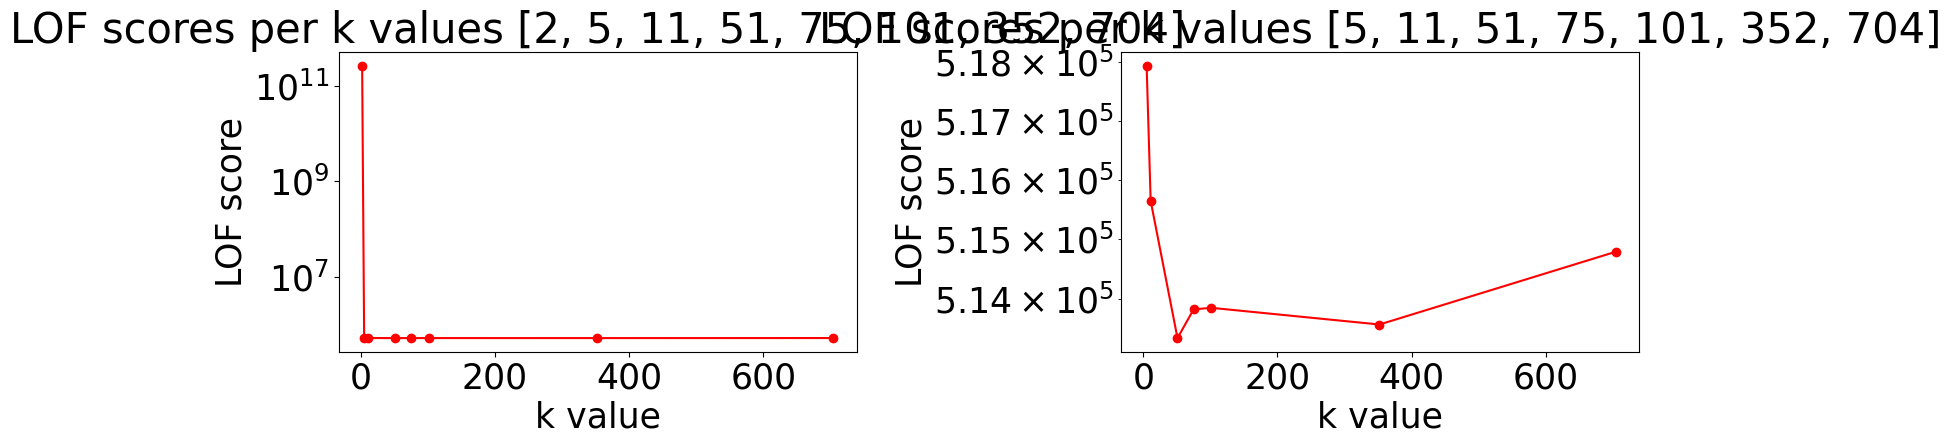

In [96]:
plt.clf()
lof_scores_arr = np.array([lof_scores[scores] for scores in lof_scores])
lof_scores_arr = np.sum(lof_scores_arr, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(neighbor_values[i:], lof_scores_arr[i:], '-ro')
    ax.set_title(f'LOF scores per k values {neighbor_values[i:]}')

    ax.set_xlabel('k value')
    ax.set_ylabel('LOF score')
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [97]:
curr_pred = np.array([preds[k] for k in preds])
curr_pred[curr_pred == 1] = 0
curr_pred[curr_pred == -1] = 1
sum_anomalies = np.sum(curr_pred, axis=1)

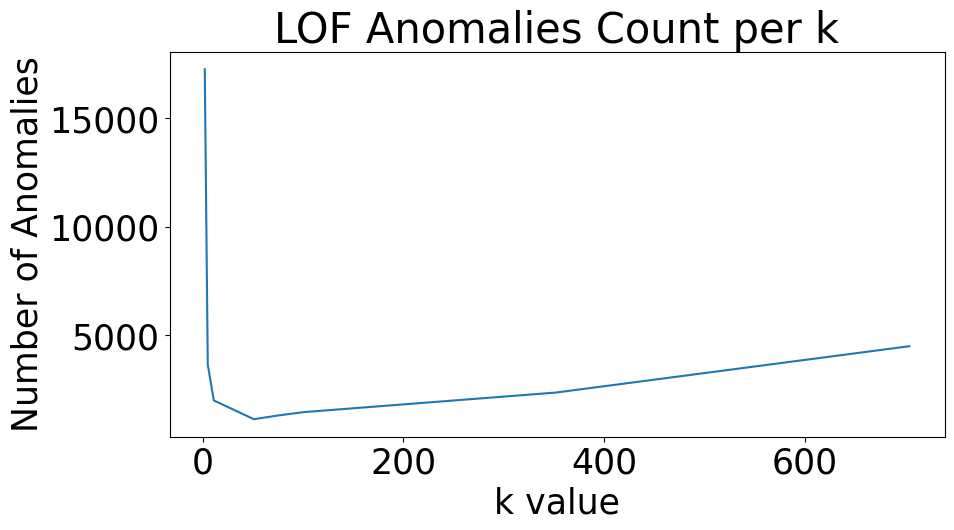

In [98]:
plt.figure(figsize=(10, 5))

plt.plot(neighbor_values, sum_anomalies)

plt.title("LOF Anomalies Count per k")

plt.xlabel("k value")
plt.ylabel("Number of Anomalies")

plt.show()

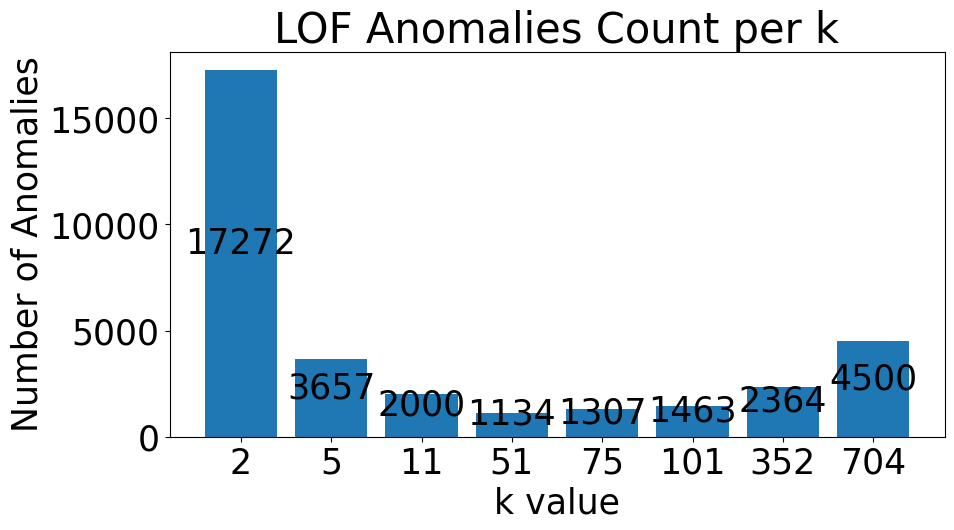

In [99]:
# function to add value labels
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha='center')


plt.figure(figsize=(10, 5))

plt.bar([f"{k}" for k in neighbor_values], sum_anomalies)

addlabels(neighbor_values, sum_anomalies)

plt.title("LOF Anomalies Count per k")

plt.xlabel("k value")
plt.ylabel("Number of Anomalies")

plt.show()

/tmp/ipykernel_30/581734376.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)


<Figure size 640x480 with 0 Axes>

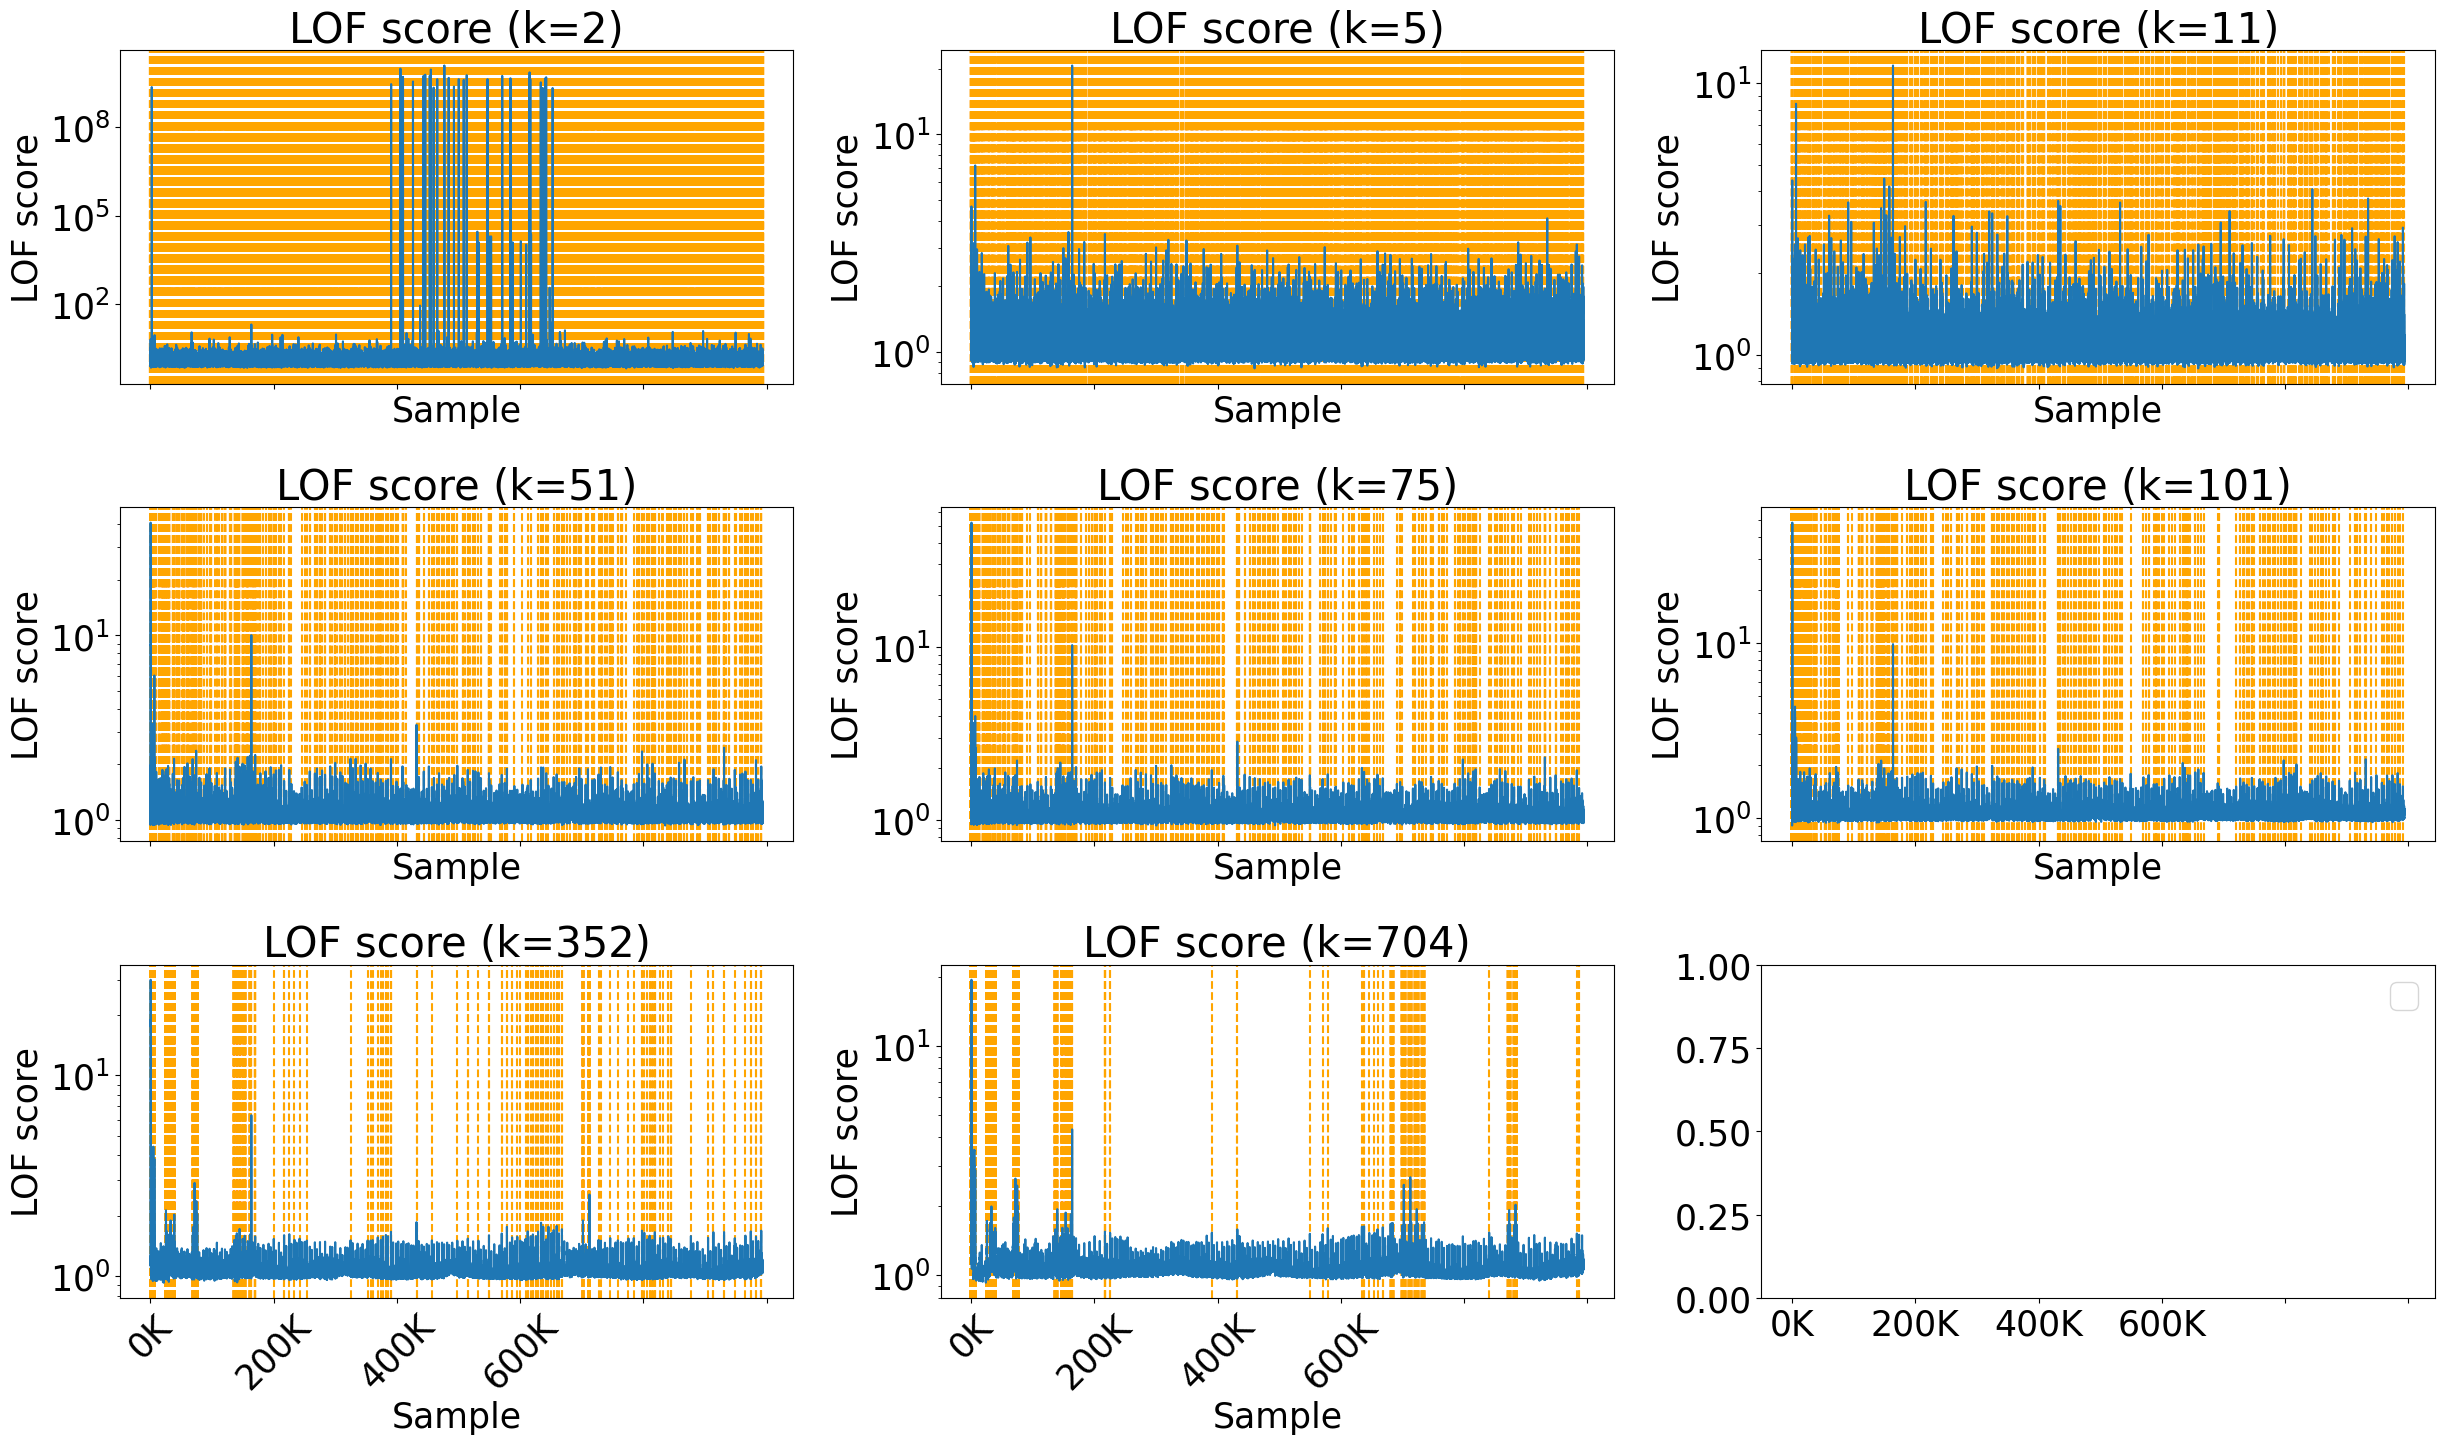

In [100]:
sqr_fig = int(np.ceil(np.sqrt(len(k_vals))))

plt.rcParams.update({'font.size': 25})
plt.clf()

fig, axes = plt.subplots(sqr_fig, sqr_fig, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    if i >= len(k_vals):
        break
    arr = lof_scores[k_vals[i]]

    max_value = np.max(arr)
    curr_pred = np.array(preds[k_vals[i]])
    curr_pred[curr_pred == 1] = 0
    curr_pred[curr_pred == -1] = max_value

    indexes = np.where(curr_pred != 0)[0]
    for index in indexes:
        ax.axvline(index, linestyle='--', color="orange")
    ax.plot(np.arange(len(arr)), arr)

    ax.set_title(f'LOF score (k={k_vals[i]})')

    ax.set_xlabel('Sample')
    ax.set_ylabel('LOF score')
    ax.set_yscale('log')
    xlabels = [f'{x:,.0f}K' for x in ax.get_xticks()/1000]
    ax.set_xticklabels(xlabels, rotation=45)

plt.tight_layout()
plt.legend(["LOF", "isOutlier"])
plt.show()

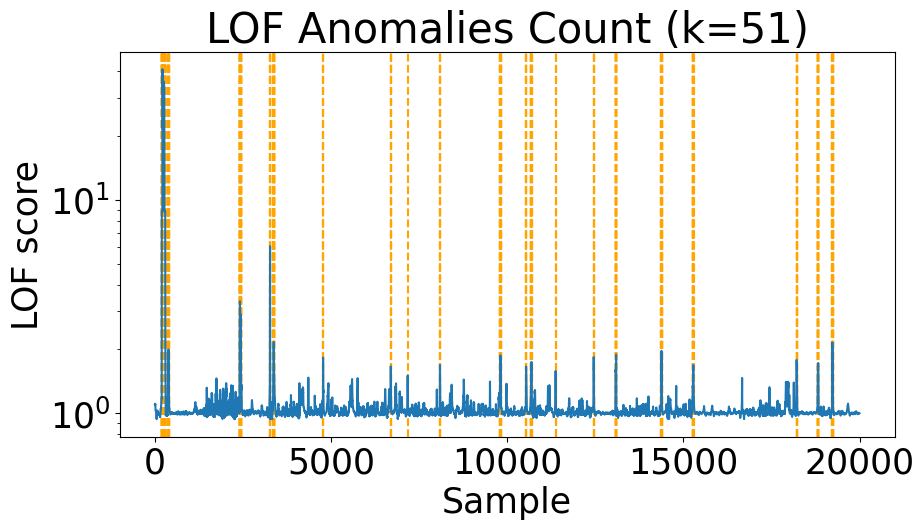

In [101]:
plt.figure(figsize=(10, 5))

anomalies_k_51 = np.array(lof_scores[51][:20000])
curr_pred = np.array(preds[51][:20000])
curr_pred[curr_pred == 1] = 0
curr_pred[curr_pred == -1] = 1

indexes = np.where(curr_pred == 1)[0]
for index in indexes:
    plt.axvline(index, linestyle='--', color="orange")

plt.plot(np.arange(len(anomalies_k_51)), anomalies_k_51)

plt.title("LOF Anomalies Count (k=51)")

plt.xlabel("Sample")
plt.ylabel("LOF score")
plt.yscale('log')
plt.show()

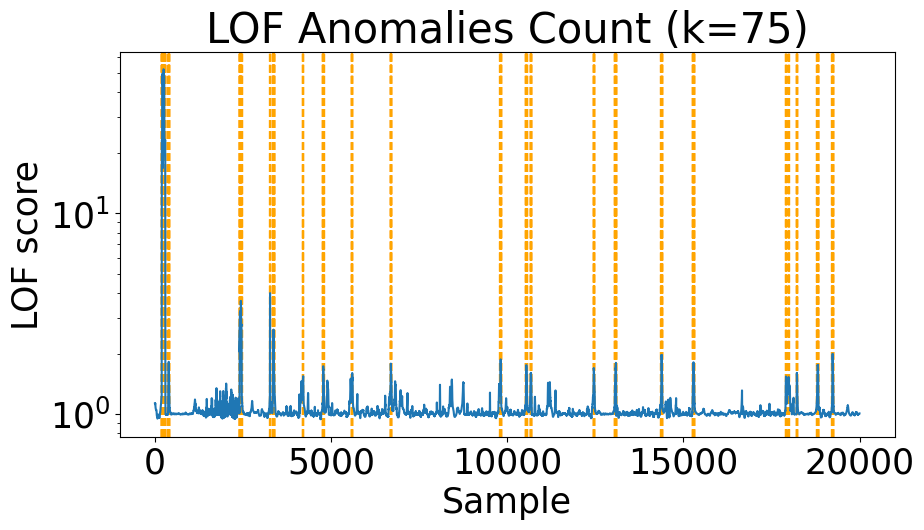

In [102]:
plt.figure(figsize=(10, 5))

anomalies_k_75 = np.array(lof_scores[75][:20000])
curr_pred = np.array(preds[75][:20000])
curr_pred[curr_pred == 1] = 0
curr_pred[curr_pred == -1] = 1

indexes = np.where(curr_pred == 1)[0]
for index in indexes:
    plt.axvline(index, linestyle='--', color="orange")

plt.plot(np.arange(len(anomalies_k_75)), anomalies_k_75)

plt.title("LOF Anomalies Count (k=75)")

plt.xlabel("Sample")
plt.ylabel("LOF score")
plt.yscale('log')
plt.show()

In [111]:
curr_pred = np.array(preds[51][:20000])

abnormal_indexes = np.where(curr_pred == -1)[0]
train_data_no_anomalies_df = train_data_df.drop(train_data_df.index[indexes])[relevant_attributes]

In [112]:
clf = LocalOutlierFactor(n_neighbors=51, n_jobs=-1)
pred = clf.fit_predict(train_data_no_anomalies_df)
lof_score = - clf.negative_outlier_factor_

In [113]:
# Number of outliers
len(np.where(pred == -1)[0])

949

In [114]:
# Sum of LOF scores
np.sum(lof_score)

510653.3246186522

In [115]:
curr_pred = np.array(preds[75][:20000])

abnormal_indexes = np.where(curr_pred == -1)[0]

In [116]:
clf = LocalOutlierFactor(n_neighbors=75, n_jobs=-1)
pred = clf.fit_predict(train_data_no_anomalies_df)
lof_score = - clf.negative_outlier_factor_

In [117]:
# Number of outliers
len(np.where(pred == -1)[0])

1100

In [118]:
# Sum of LOF scores
np.sum(lof_score)

510088.7471134655

### 2b. Analysis and answers to the questions

We chose four sensors to analyze for anomalies all the attributes that are not . We executed LOF for 2, 5, 11, 51, 75, 101, 352 (half of the last value) and 704 (square root of data length) neighbors. We first took lower values, like 2 and 5, then some odd values, half of the square root of the data length (352) and the square root of the data length (704).

For k value, usually, the lower values of k tend to make the algorithm more sensitive to outliers since they have a larger impact on the calculation of distances and neighbor relations. The higher k values can provide a smoother decision boundary and may be less influenced by individual outliers. As we can see, the from the score sums of LOF, the lower k values for NN, causes the LOF to be too sensitive whereas the 
higher values are less sensitive. A common occurence seems to be that the first values seem to be abnormal which is likely because the sub-systems are getting setup and they not started any of their regular cycles.

As we can see from the total LOF scores and anolalies count, k=51 seems to the smallest and after further investivation of removing these anomalies, it seems that 51 seems to be less sensitive to small outliers.

Due to many features, LOF can be used to model point anomalies faily well. However, this is heavily impaired by its slow runtime.

## 5. N-gram task – 1/2 A4 - Individual

### 5a. Visualise discretization

#### Discretization

In [190]:
# Convert date_column to DateTime format
train_data_df['Timestamp'] = pd.to_datetime(train_data_df['Timestamp'])

# Sort DataFrame by date_column
df = train_data_df.sort_values('Timestamp')

# Select columns to discretize
columns_to_discretize = ["AIT203", "LIT101"]

In [191]:
# Initialize the discretizer

n_bins = 10
discretizer_ait = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
data_to_discretize = df[["AIT203"]].to_numpy()
discretizer_ait.fit(data_to_discretize)
discretized_data_ait = np.squeeze(discretizer_ait.transform(data_to_discretize))

discretizer_lit = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
data_to_discretize = df[["LIT101"]].to_numpy()
discretizer_lit.fit(data_to_discretize)
discretized_data_lit = np.squeeze(discretizer_lit.transform(data_to_discretize))

discretized_data = np.array([discretized_data_ait, discretized_data_lit]).T
discretized_data

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [3., 4.],
       [3., 4.],
       [3., 4.]])

In [192]:
discretized_df = pd.DataFrame(discretized_data, columns=[f'{col}_percentile' for col in columns_to_discretize])
discretized_df['Timestamp'] = train_data_df['Timestamp']
# create a dataframe
discretized_df = discretized_df.reindex(columns = ['Timestamp','AIT203_percentile','LIT101_percentile'])
discretized_df

,Timestamp,AIT203_percentile,LIT101_percentile
0,2015-12-22 16:00:00,0.0,0.0
1,2015-12-22 16:00:01,0.0,0.0
2,2015-12-22 16:00:02,0.0,0.0
3,2015-12-22 16:00:03,0.0,0.0
4,2015-12-22 16:00:04,0.0,0.0
...,...,...,...
496795,2015-12-28 09:59:55,3.0,4.0
496796,2015-12-28 09:59:56,3.0,4.0
496797,2015-12-28 09:59:57,3.0,4.0
496798,2015-12-28 09:59:58,3.0,4.0


In [193]:
def discrete_values(disc, data):
    vectorizer = np.vectorize(lambda x: int(disc.bin_edges_[0][int(x)]))
    return vectorizer(data)
    

disc_vals_df = discretized_df.drop("Timestamp", axis=1)
disc_vals_df['AIT203_discretized'] = discrete_values(discretizer_ait, discretized_data_ait)
disc_vals_df['LIT101_discretized'] = discrete_values(discretizer_lit, discretized_data_lit)
disc_vals_df

,AIT203_percentile,LIT101_percentile,AIT203_discretized,LIT101_discretized
0,0.0,0.0,300,120
1,0.0,0.0,300,120
2,0.0,0.0,300,120
3,0.0,0.0,300,120
4,0.0,0.0,300,120
...,...,...,...,...
496795,3.0,4.0,328,518
496796,3.0,4.0,328,518
496797,3.0,4.0,328,518
496798,3.0,4.0,328,518


<Figure size 640x480 with 0 Axes>

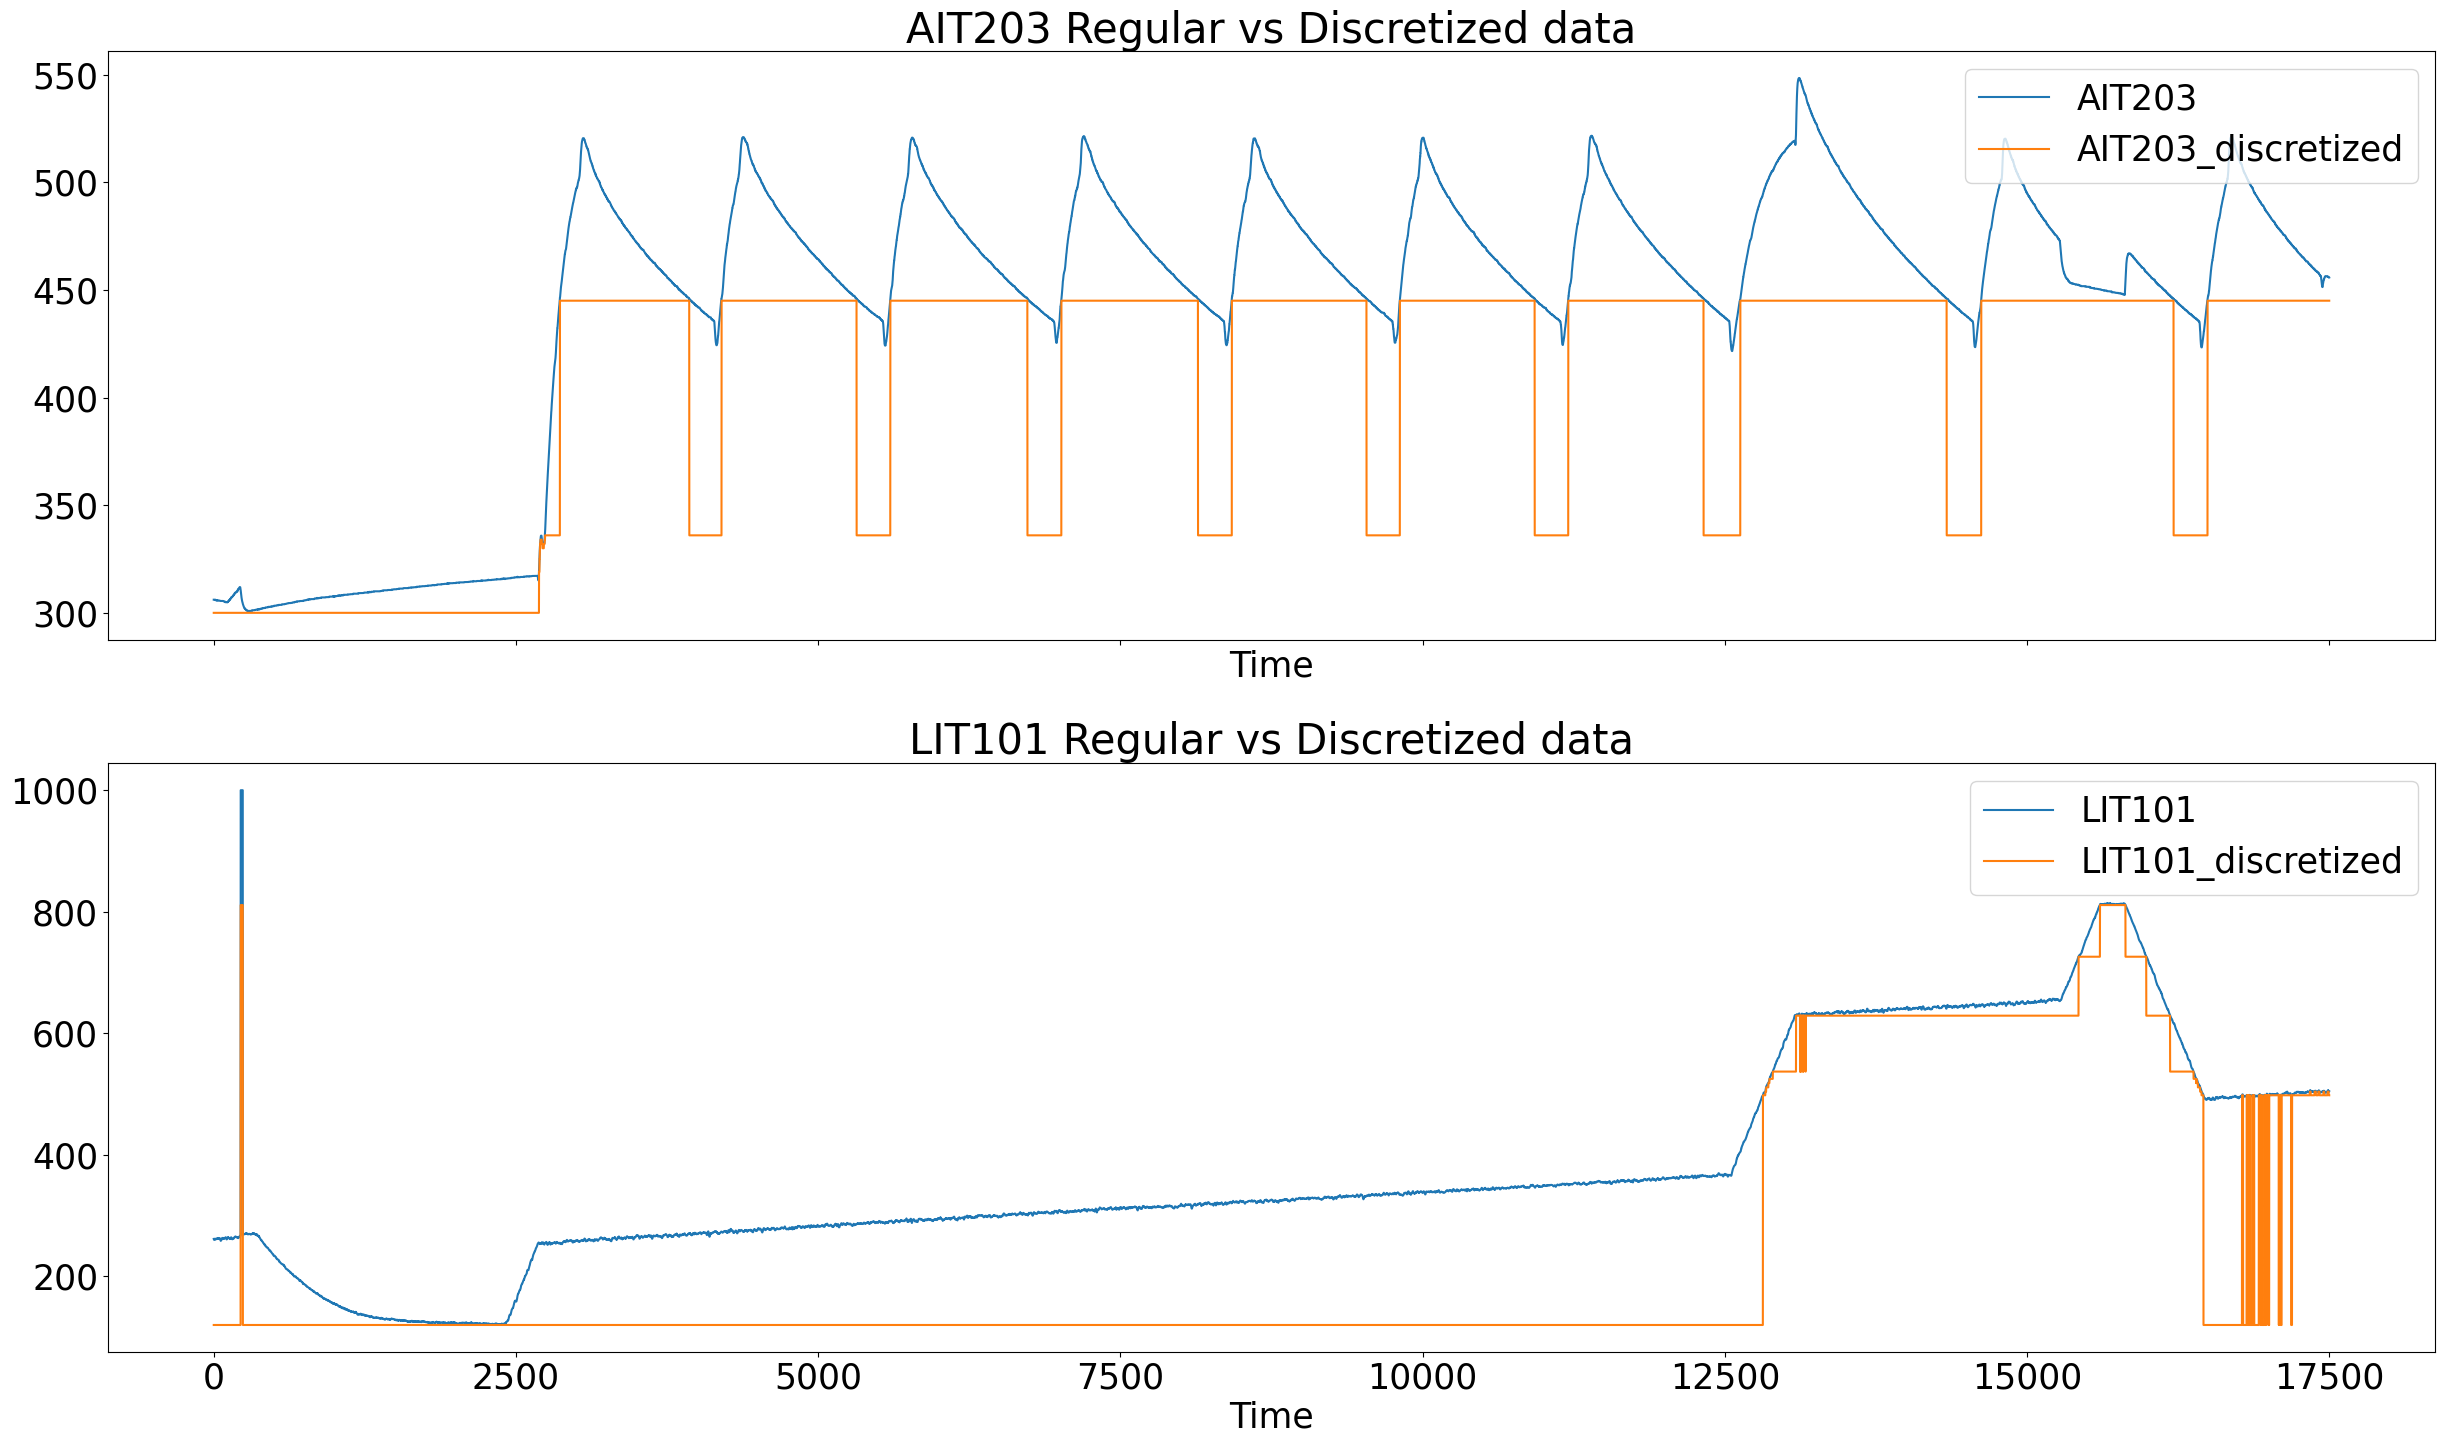

In [194]:
plt.clf()

time_max = 17_500

regular_columns = ["AIT203", "LIT101"]
discretised_columns = ["AIT203_discretized", "LIT101_discretized"]

fig, axes = plt.subplots(2, 1, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(df[regular_columns[i]].to_numpy()[:time_max])
    ax.plot(disc_vals_df[discretised_columns[i]].to_numpy()[:time_max])
    ax.set_title(f'{regular_columns[i]} Regular vs Discretized data')
    ax.set_xlabel('Time')
    ax.legend(labels=[regular_columns[i], discretised_columns[i]], loc='upper right')
plt.tight_layout()
plt.show()

#### N-grams

In [224]:
def build_n_grams_with_count(data, window_length, window_step=1, count=True):
    ngrams = [] if count else set()
    for i in range(0, data.shape[0] - window_length, window_step):
        window = str(data[i:i+window_length])
        if count:
            ngrams.append(window)
        else:
            ngrams.add(window)
    if count:
        ngram_counter = Counter(ngrams)
        return ngram_counter
    return set(ngrams)

In [215]:
discretized_data_ait = disc_vals_df['AIT203_discretized'].to_numpy()[:time_max]
discretized_data_lit = disc_vals_df['LIT101_discretized'].to_numpy()[:time_max]

In [216]:
ait_3gram = build_n_grams_with_count(discretized_data_ait, 3)
print("AIT203 3-grams count: ", len(ait_3gram))
ait_3gram

AIT203 3-grams count:  29


Counter({'[445 445 445]': 12083,
         '[300 300 300]': 2689,
         '[336 336 336]': 2635,
         '[332 332 332]': 10,
         '[334 334 334]': 10,
         '[336 336 445]': 10,
         '[336 445 445]': 10,
         '[330 330 330]': 9,
         '[445 445 336]': 9,
         '[445 336 336]': 9,
         '[319 319 319]': 2,
         '[330 332 332]': 2,
         '[332 332 334]': 2,
         '[332 334 334]': 2,
         '[300 300 319]': 1,
         '[300 319 319]': 1,
         '[319 319 325]': 1,
         '[319 325 325]': 1,
         '[325 325 328]': 1,
         '[325 328 329]': 1,
         '[328 329 330]': 1,
         '[329 330 332]': 1,
         '[334 334 332]': 1,
         '[334 332 332]': 1,
         '[332 332 330]': 1,
         '[332 330 330]': 1,
         '[330 330 332]': 1,
         '[334 334 336]': 1,
         '[334 336 336]': 1})

In [217]:
lit_3gram = build_n_grams_with_count(discretized_data_lit, 3)
print("LIT101 3-grams count: ", len(lit_3gram))
lit_3gram

LIT101 3-grams count:  55


Counter({'[120 120 120]': 13242,
         '[629 629 629]': 2510,
         '[498 498 498]': 500,
         '[537 537 537]': 383,
         '[726 726 726]': 345,
         '[811 811 811]': 225,
         '[504 504 504]': 49,
         '[525 525 525]': 45,
         '[511 511 511]': 32,
         '[120 120 498]': 17,
         '[518 518 518]': 17,
         '[120 498 498]': 16,
         '[498 120 120]': 16,
         '[498 498 120]': 15,
         '[498 498 504]': 6,
         '[498 504 504]': 6,
         '[504 504 498]': 6,
         '[504 498 498]': 6,
         '[537 629 629]': 5,
         '[629 629 537]': 5,
         '[537 537 629]': 4,
         '[629 537 537]': 4,
         '[120 498 120]': 4,
         '[629 537 629]': 3,
         '[498 120 498]': 3,
         '[518 518 525]': 2,
         '[537 629 537]': 2,
         '[525 518 518]': 2,
         '[120 120 811]': 1,
         '[120 811 811]': 1,
         '[811 811 120]': 1,
         '[811 120 120]': 1,
         '[504 504 511]': 1,
         '[504 511 5

In [242]:
def build_ngram_train_data(data, ngram_size, ngram_step, data_window_size, data_window_step):
    ngrams_names = build_n_grams_with_count(data, ngram_size, window_step=ngram_step, count=False)
    ngram_df_data = {key:[] for key in ngrams_names}

    for i in range(0, data.shape[0] - data_window_size, data_window_step):
        window = data[i:i+data_window_size]
        ngram_counter = build_n_grams_with_count(window, ngram_size, window_step=ngram_step)
        for n_gram in ngrams_names:
            if n_gram in ngram_counter:
                ngram_df_data[n_gram].append(ngram_counter[n_gram])
            else:
                ngram_df_data[n_gram].append(0)
        
    return pd.DataFrame(ngram_df_data)



In [243]:
discretized_data_ait = disc_vals_df['AIT203_discretized'].to_numpy()
occurrence_ait_df = build_ngram_train_data(discretized_data_ait, 3, 1, 100, 100)
occurrence_ait_df

,[334 334 336],[334 334 332],[336 336 336],[445 336 336],[328 328 328],[329 330 330],[325 328 329],[329 328 328],[330 332 330],[328 328 330],...,[336 336 445],[330 330 329],[319 319 300],[334 336 336],[336 445 445],[300 319 319],[329 329 330],[300 300 319],[319 300 300],[325 325 329]
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,0,0,0,0,97,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4963,0,0,0,0,97,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4964,0,0,0,0,97,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4965,0,0,0,0,97,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [244]:
discretized_data_lit = disc_vals_df['LIT101_discretized'].to_numpy()
occurrence_lit_df = build_ngram_train_data(discretized_data_lit, 3, 1, 100, 100)
occurrence_lit_df

,[726 811 726],[811 726 811],[811 120 120],[629 629 629],[120 120 811],[726 811 811],[504 504 511],[511 518 511],[511 511 504],[498 498 498],...,[537 629 537],[726 726 811],[537 537 629],[525 518 518],[518 511 511],[504 498 498],[629 726 629],[504 504 504],[498 504 504],[629 726 726]
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,0,0,0,0,0,0,2,0,2,0,...,0,0,0,0,0,0,0,7,0,0
4963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4965,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0


In [267]:
def train_ngram_nn(data, k=1):
    nbrs = NearestNeighbors(n_neighbors=k, metric='cosine')
    nbrs.fit(data)
    residuals, _ = nbrs.kneighbors(data)
    return residuals

In [281]:
# Picked k from LOF analysis
picked_k = 51

residuals_ait = train_ngram_nn(occurrence_ait_df, k=picked_k)
residuals_lit = train_ngram_nn(occurrence_lit_df, k=picked_k)

residuals = [residuals_ait, residuals_lit]

<Figure size 640x480 with 0 Axes>

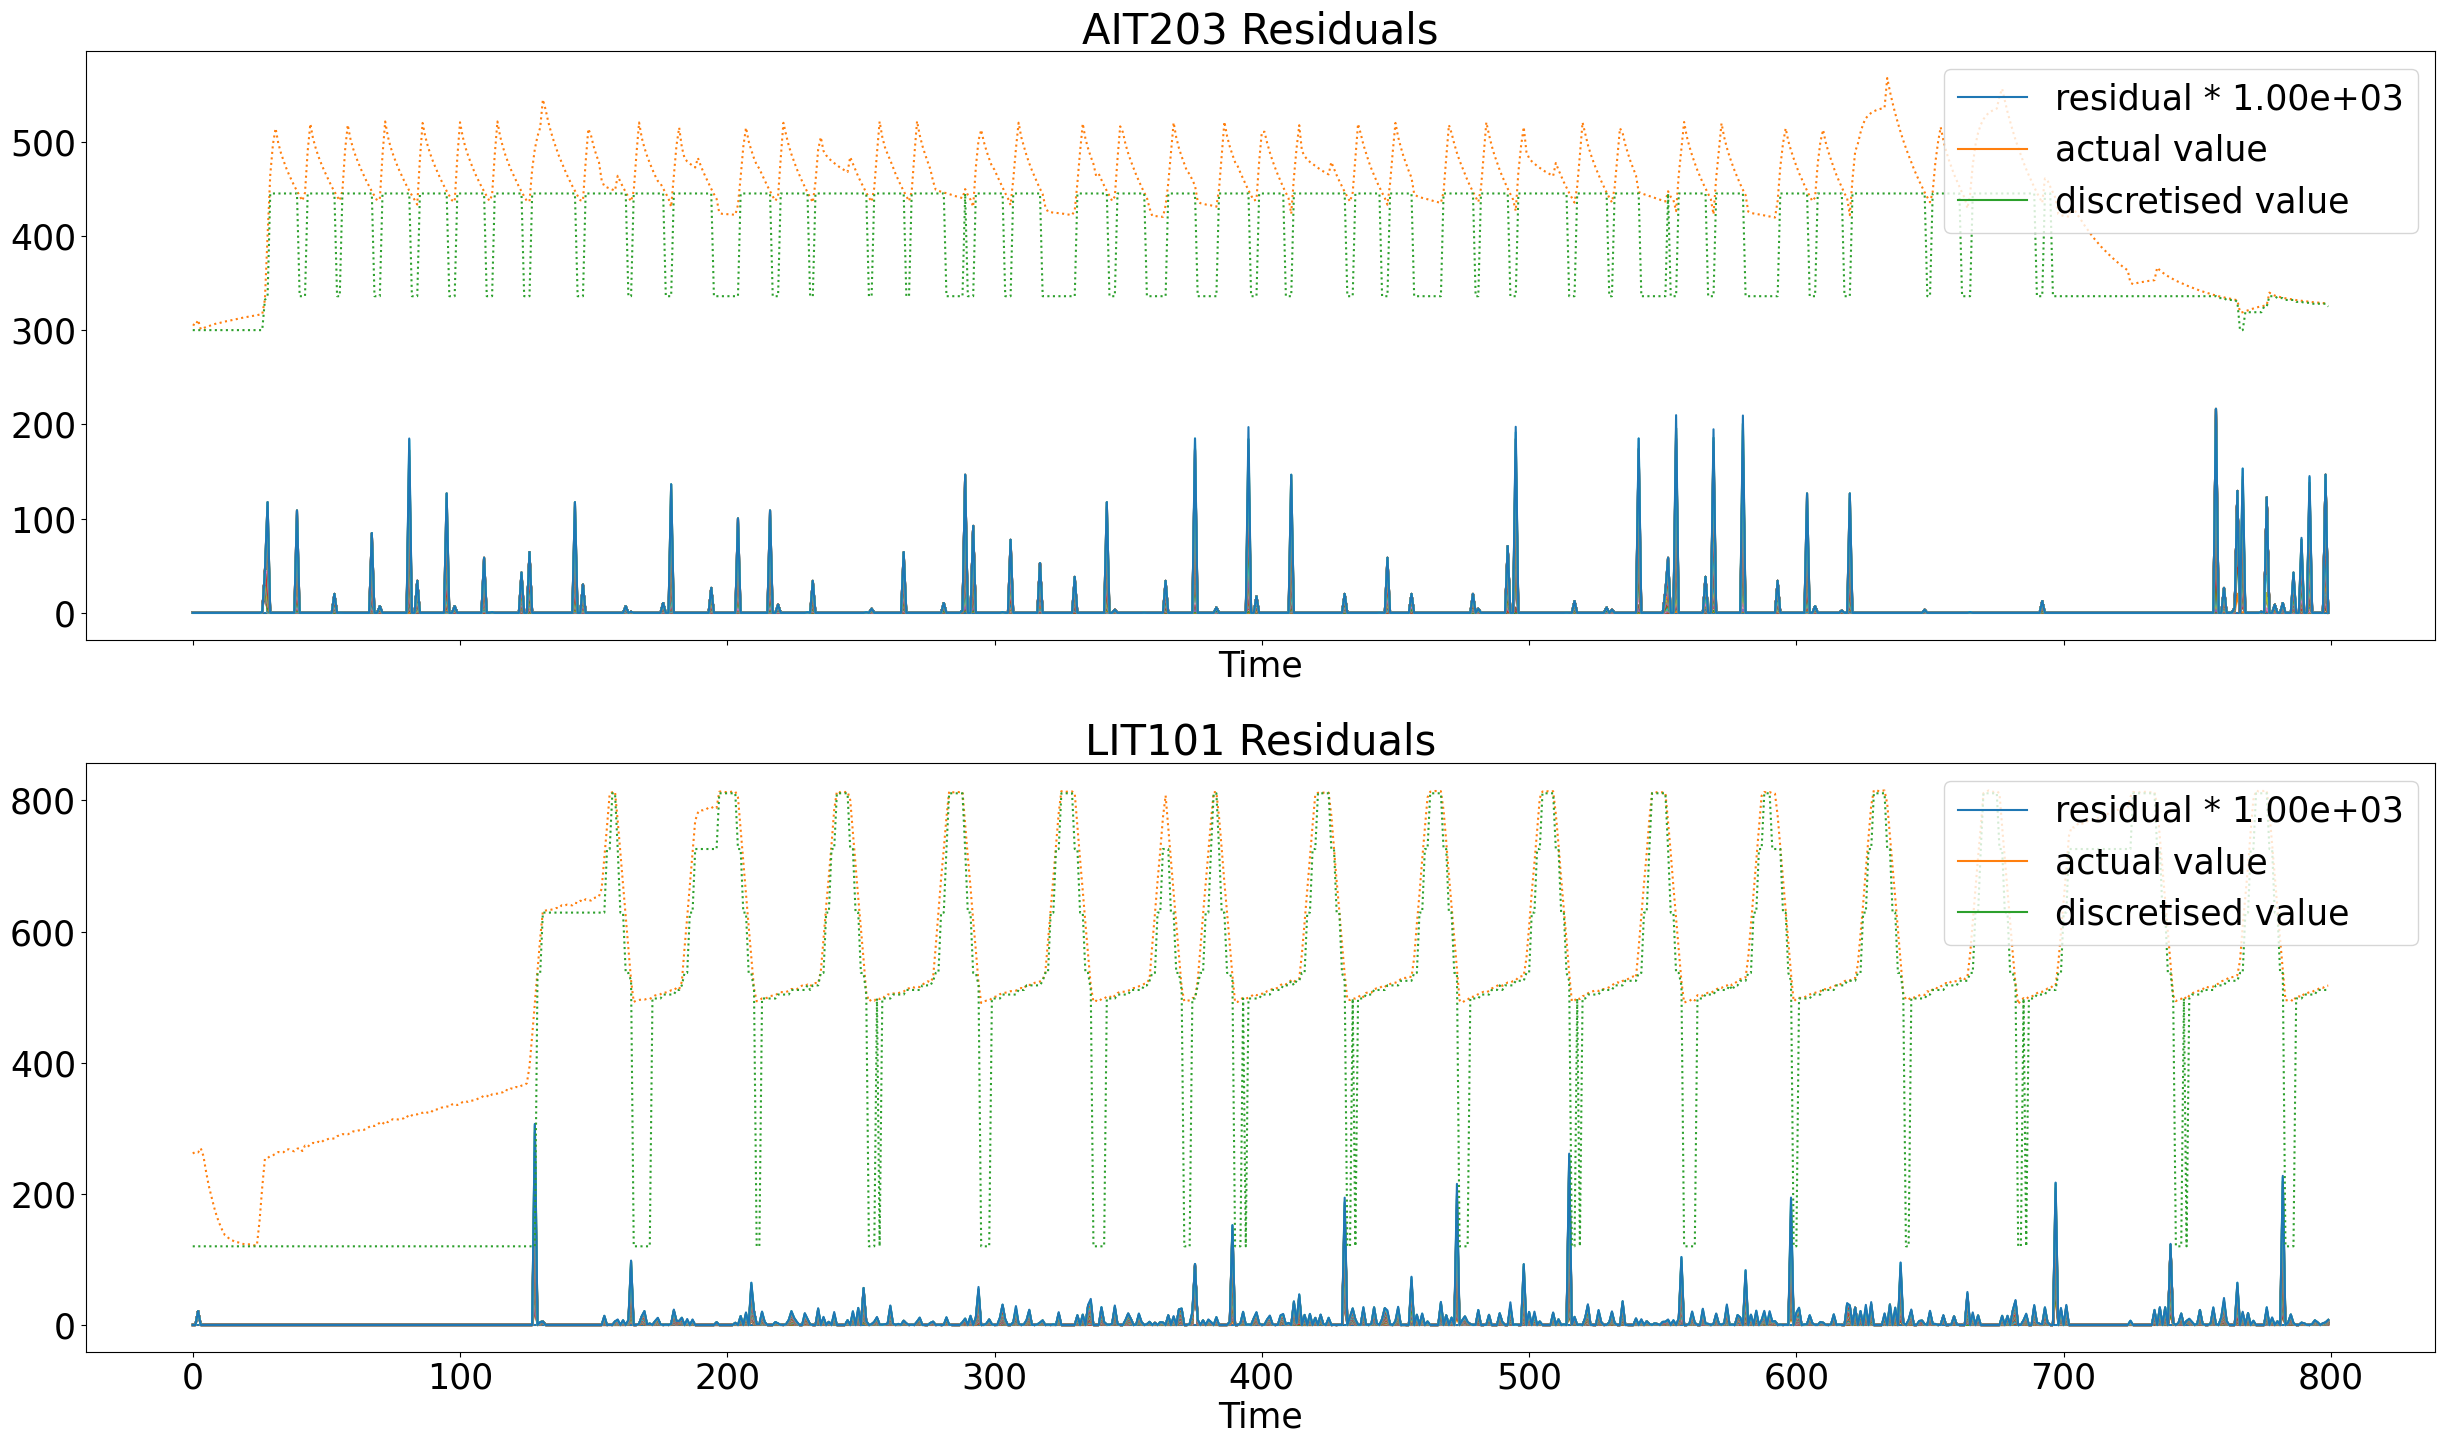

In [284]:
plt.clf()

max_time = 800
power = 3

regular_columns = ["AIT203", "LIT101"]
fig, axes = plt.subplots(2, 1, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    #Scaled residuals 10^power
    res = residuals[i] * pow(10, power)
    ax.plot(res[:max_time])
    
    #Sub-sampled values to fit residuals length
    values = df[regular_columns[i]].to_numpy()
    values = values[::len(values)//len(residuals[i])]
    ax.plot(values[:max_time], linestyle=':')
    
    #Sub-sampled discretised values to fit residuals length
    values = disc_vals_df[discretised_columns[i]].to_numpy()
    values = values[::len(values)//len(residuals[i])]
    ax.plot(values[:max_time], linestyle=':')
    
    ax.set_title(f'{regular_columns[i]} Residuals')
    ax.legend(labels=[f"residual * {pow(10, power):.2e}", "actual value", "discretised value"], loc='upper right')
    ax.set_xlabel('Time')
plt.tight_layout()
plt.show()

#### Differencing sensor data

In [292]:
# Convert date_column to DateTime format
train_data_df['Timestamp'] = pd.to_datetime(train_data_df['Timestamp'])

# Sort DataFrame by date_column
df = train_data_df.sort_values('Timestamp')

# Select columns to discretize
columns_to_discretize = ["AIT203", "LIT101"]

ait_data = np.squeeze(df[["AIT203"]].to_numpy())
ait_data = np.diff(ait_data)

lit_data = np.squeeze(df[["LIT101"]].to_numpy())
lit_data = np.diff(lit_data)

<Figure size 640x480 with 0 Axes>

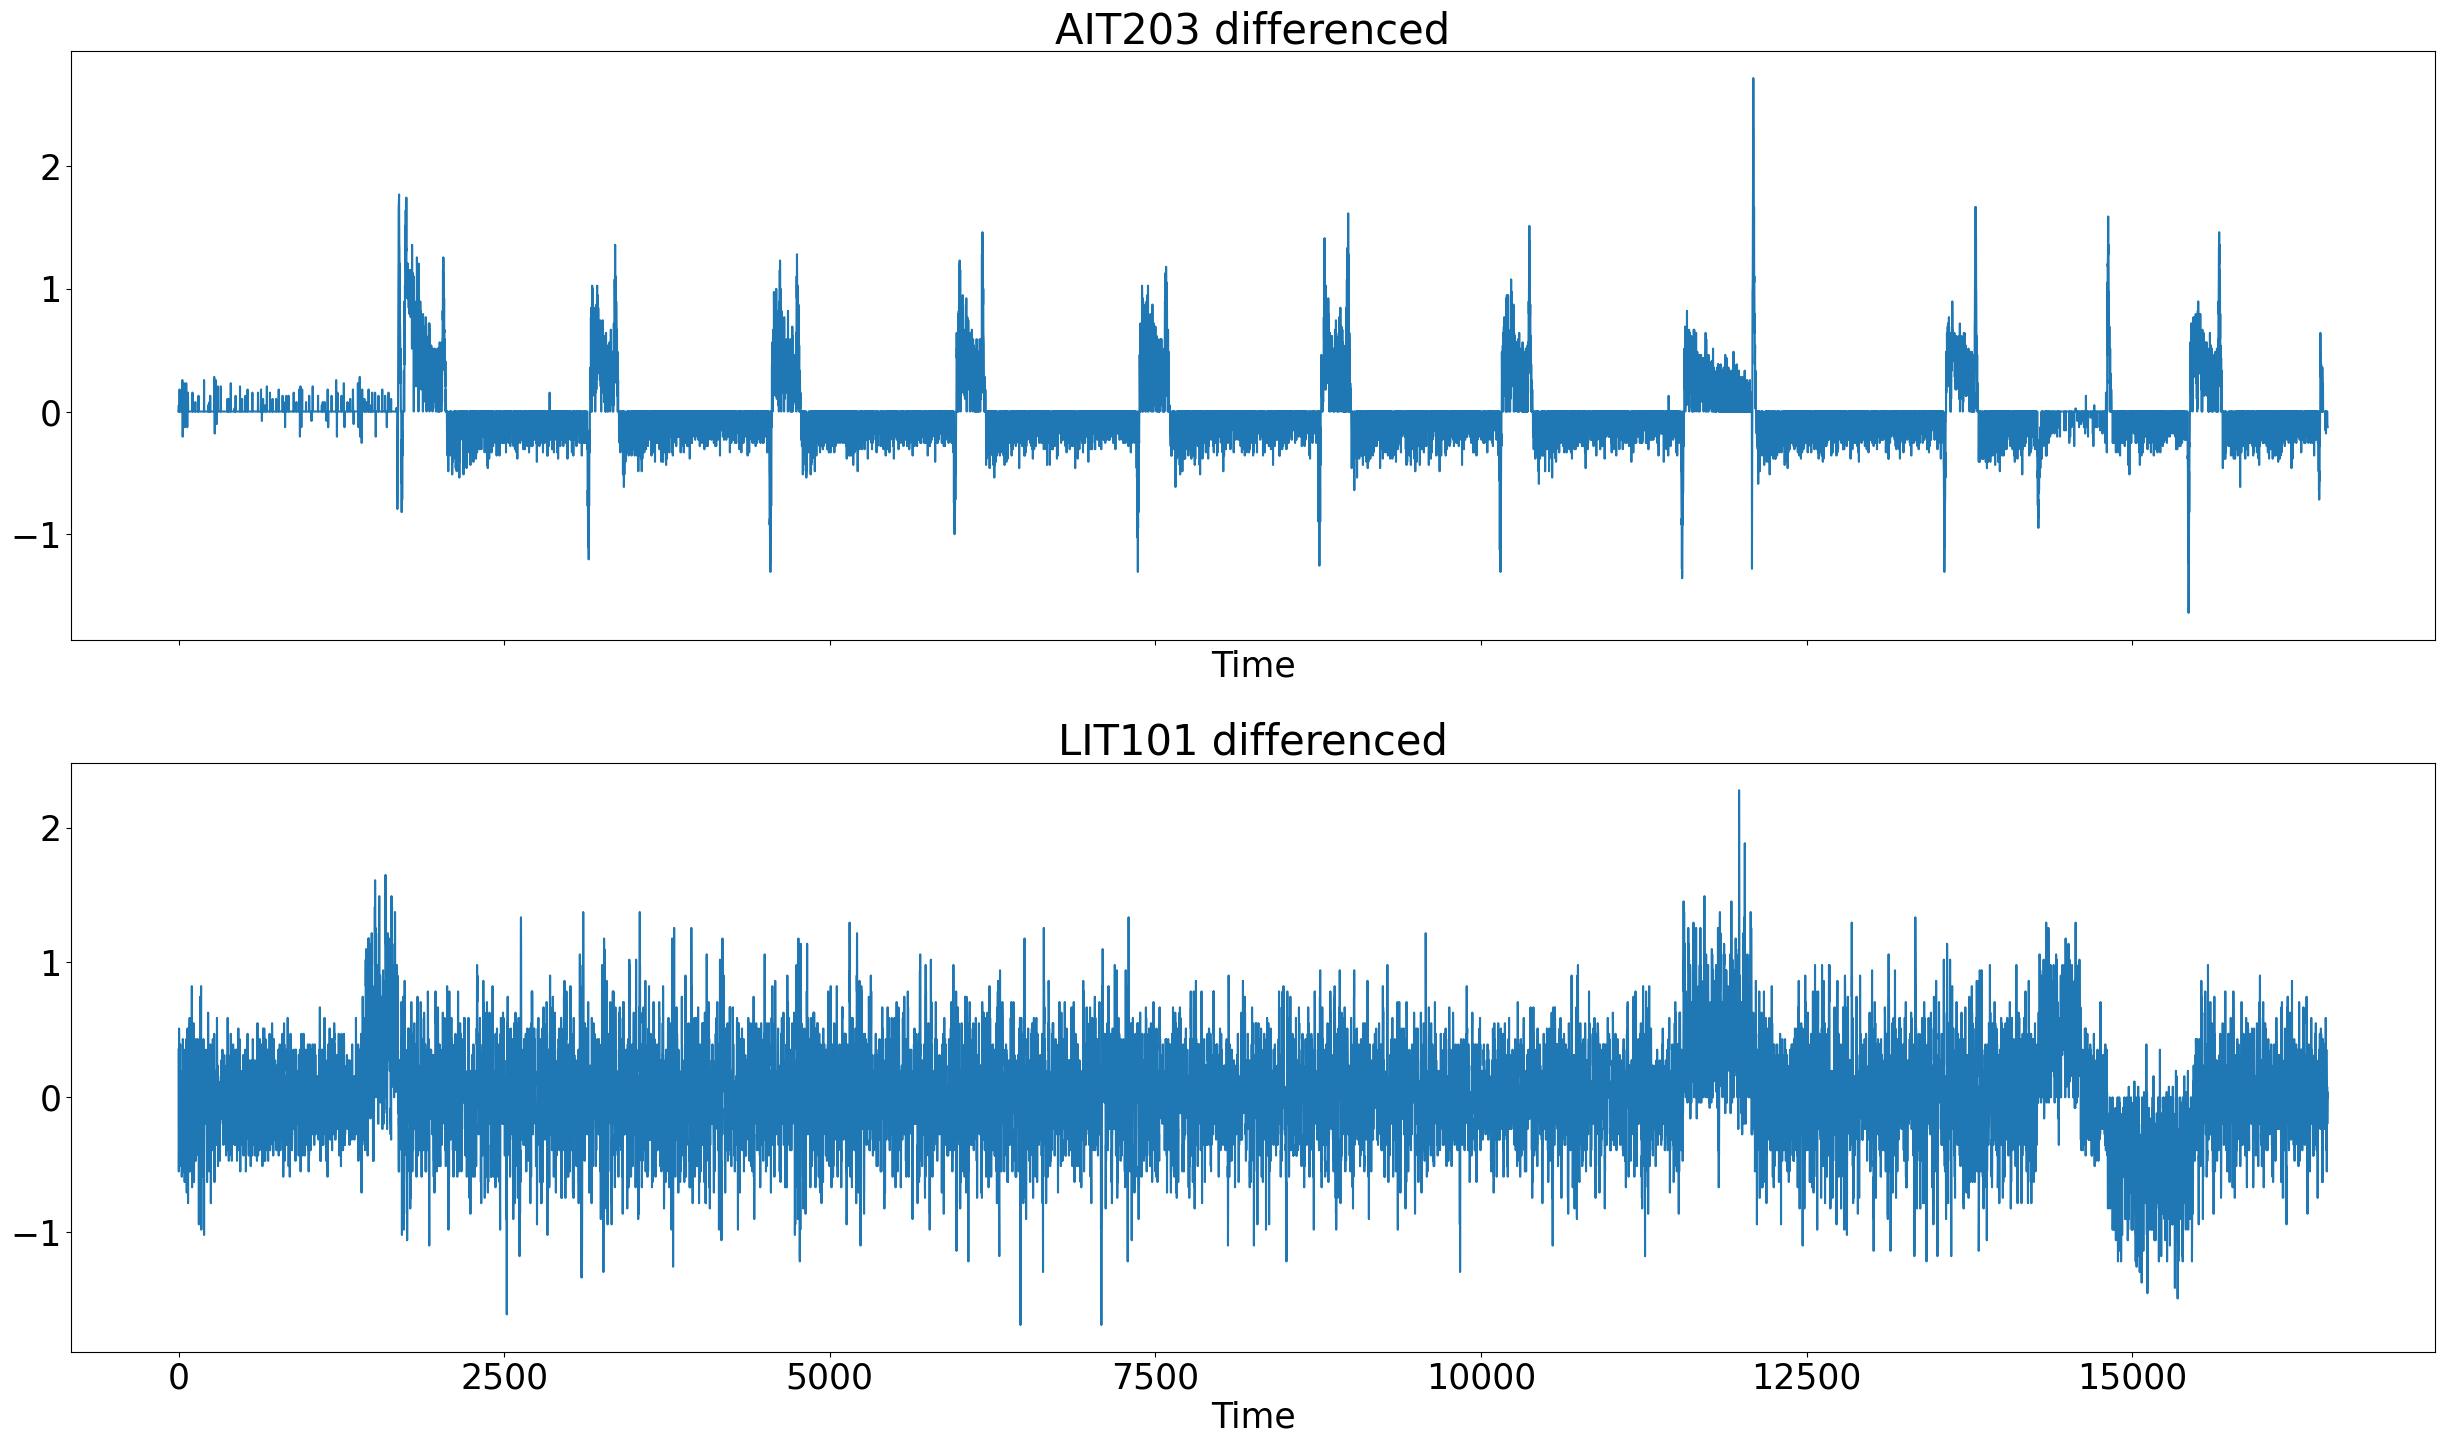

In [297]:
plt.clf()
time_start = 1_000
time_max = 17_500

diff_data = [ait_data, lit_data]

fig, axes = plt.subplots(2, 1, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(diff_data[i][time_start:time_max])
    ax.set_title(f'{columns_to_discretize[i]} differenced')
    ax.set_xlabel('Time')
plt.tight_layout()
plt.show()

In [308]:
# Initialize the discretizer
n_bins = 20_000

discretizer_ait = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
discretizer_ait.fit(ait_data.reshape(-1, 1))
discretized_data_ait = np.squeeze(discretizer_ait.transform(ait_data.reshape(-1, 1)))

discretizer_lit = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
discretizer_lit.fit(lit_data.reshape(-1, 1))
discretized_data_lit = np.squeeze(discretizer_lit.transform(lit_data.reshape(-1, 1)))


discretized_data = np.array([discretized_data_ait, discretized_data_lit]).T

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:216: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed.

In [309]:
discretized_df = pd.DataFrame(discretized_data, columns=[f'{col}_percentile' for col in columns_to_discretize])
discretized_df['Timestamp'] = train_data_df['Timestamp']

discretized_df = discretized_df.reindex(columns = ['Timestamp','AIT203_percentile','LIT101_percentile'])

discretized_df = discretized_df.drop("Timestamp", axis=1)
discretized_df['AIT203_discretized'] = discrete_values(discretizer_ait, discretized_data_ait)
discretized_df['LIT101_discretized'] = discrete_values(discretizer_lit, discretized_data_lit)
discretized_df

,AIT203_percentile,LIT101_percentile,AIT203_discretized,LIT101_discretized
0,72.0,80.0,0,0
1,72.0,87.0,0,0
2,72.0,62.0,0,0
3,72.0,80.0,0,0
4,72.0,115.0,0,0
...,...,...,...,...
496794,72.0,100.0,0,0
496795,72.0,100.0,0,0
496796,83.0,100.0,0,0
496797,72.0,106.0,0,0


<Figure size 640x480 with 0 Axes>

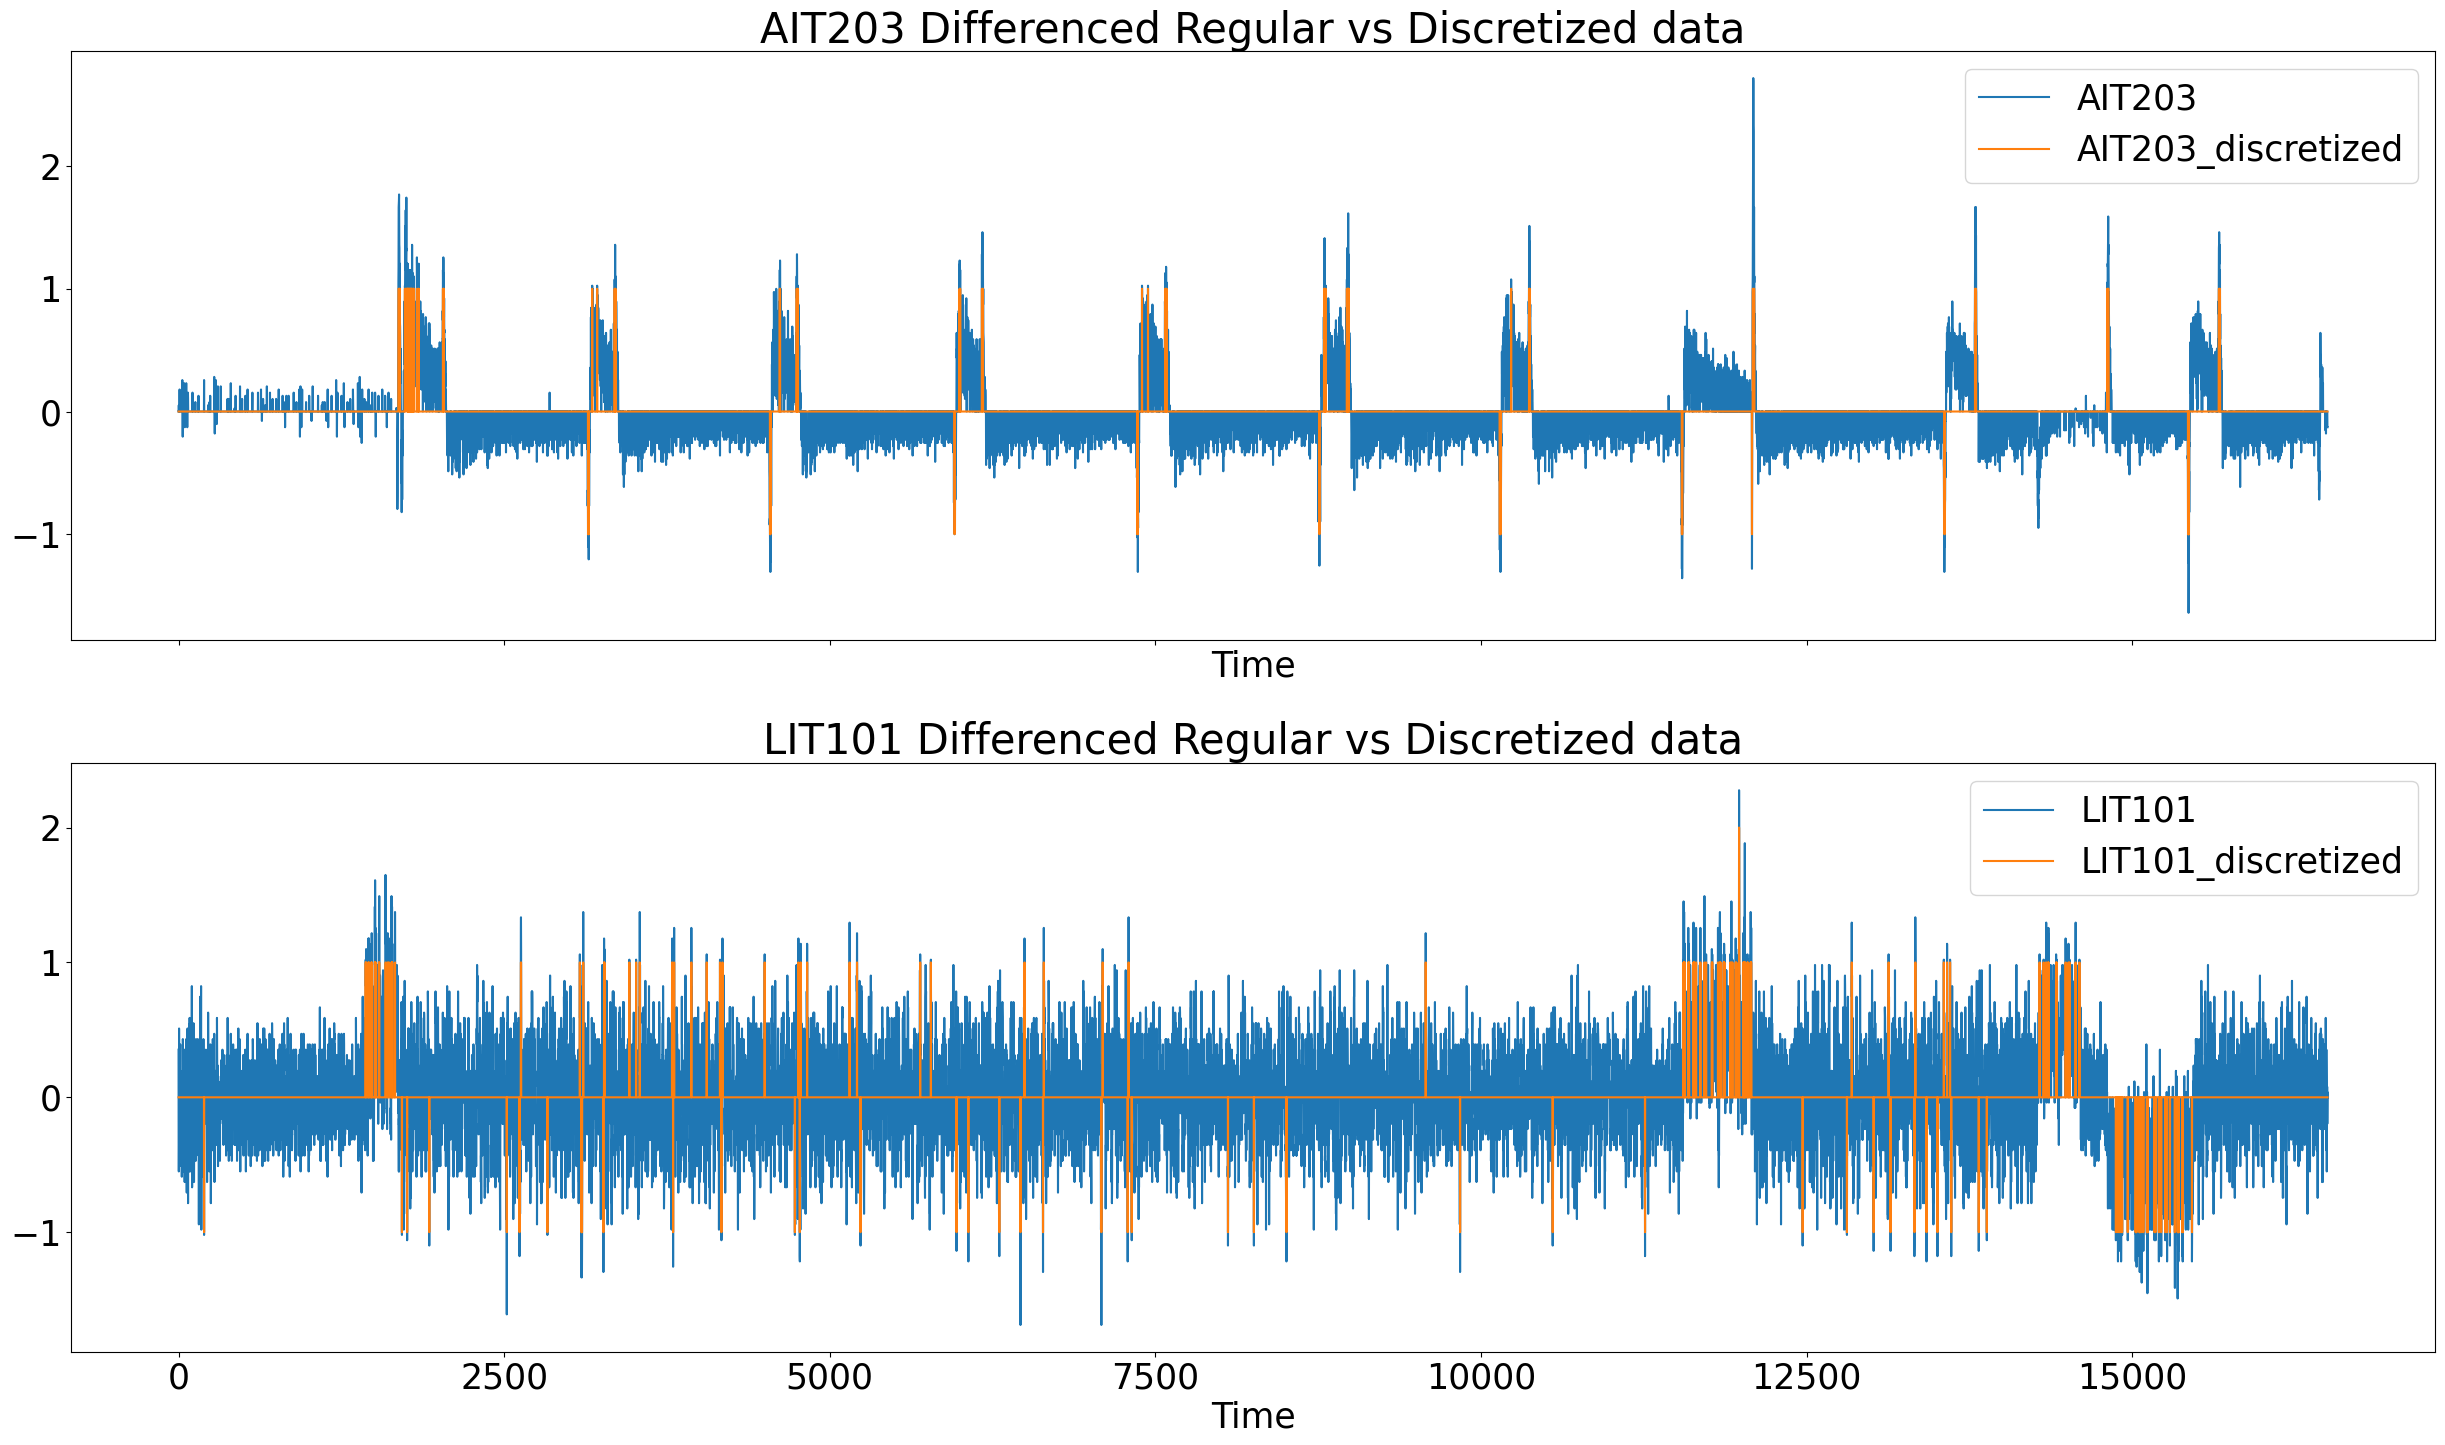

In [310]:
plt.clf()
time_start = 1_000
time_max = 17_500

diff_data = [ait_data, lit_data]

regular_columns = ["AIT203", "LIT101"]
discretised_columns = ["AIT203_discretized", "LIT101_discretized"]

fig, axes = plt.subplots(2, 1, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(diff_data[i][time_start:time_max])
    ax.plot(discretized_df[discretised_columns[i]].to_numpy()[time_start:time_max])
    ax.set_title(f'{regular_columns[i]} Differenced Regular vs Discretized data')
    ax.set_xlabel('Time')
    ax.legend(labels=[regular_columns[i], discretised_columns[i]], loc='upper right')
plt.tight_layout()
plt.show()

In [311]:
discretized_data_ait = discretized_df['AIT203_discretized'].to_numpy()
occurrence_ait_df = build_ngram_train_data(discretized_data_ait, 3, 1, 100, 100)

discretized_data_lit = disc_vals_df['LIT101_discretized'].to_numpy()
occurrence_lit_df = build_ngram_train_data(discretized_data_lit, 3, 1, 100, 100)

# Picked k from LOF analysis
picked_k = 51

residuals_ait = train_ngram_nn(occurrence_ait_df, k=picked_k)
residuals_lit = train_ngram_nn(occurrence_lit_df, k=picked_k)

residuals = [residuals_ait, residuals_lit]

<Figure size 640x480 with 0 Axes>

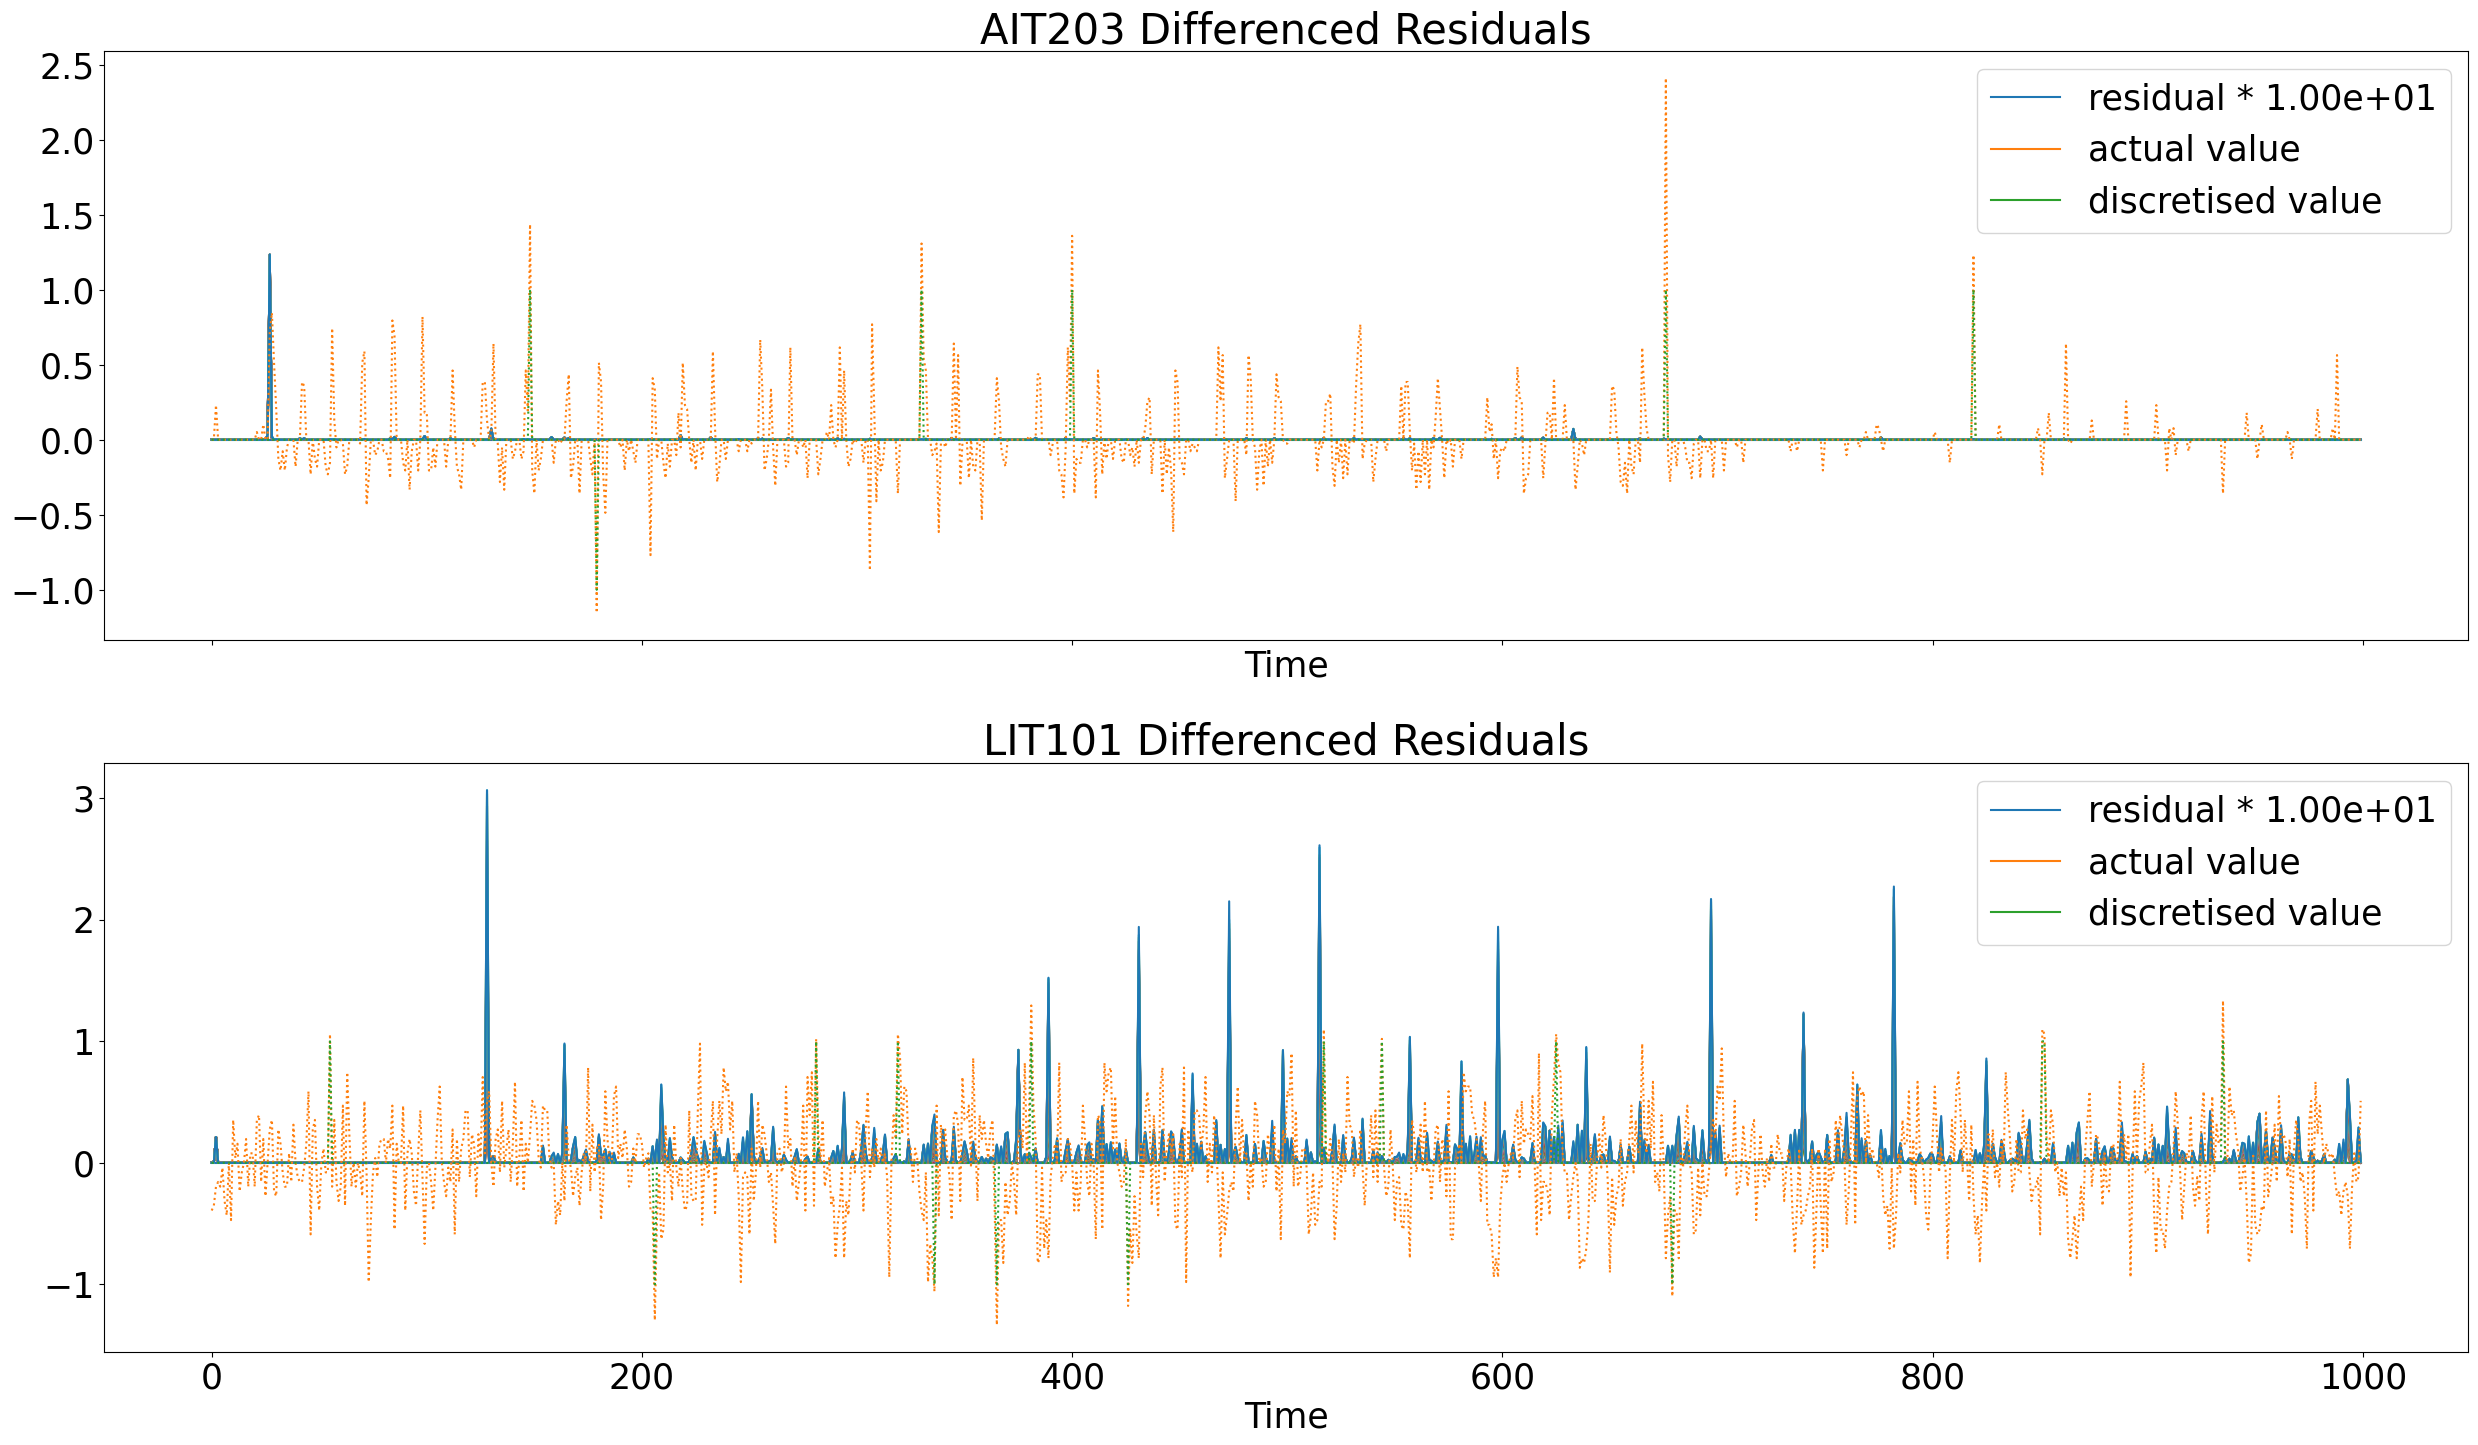

In [317]:
plt.clf()

time_start = 0
time_max = 1_000

power = 1

diff_data = [ait_data, lit_data]

regular_columns = ["AIT203", "LIT101"]
fig, axes = plt.subplots(2, 1, figsize=(25, 15), sharex=True)
for i, ax in enumerate(axes.flatten()):
    #Scaled residuals 10^power
    res = residuals[i] * pow(10, power)
    ax.plot(res[time_start:time_max])
    
    #Sub-sampled values to fit residuals length
    values = diff_data[i]
    values = values[::len(values)//len(residuals[i])]
    ax.plot(values[time_start:time_max], linestyle=':')
    
    #Sub-sampled discretised values to fit residuals length
    values = discretized_df[discretised_columns[i]].to_numpy()
    values = values[::len(values)//len(residuals[i])]
    ax.plot(values[time_start:time_max], linestyle=':')
    
    ax.set_title(f'{regular_columns[i]} Differenced Residuals')
    ax.legend(labels=[f"residual * {pow(10, power):.2e}", "actual value", "discretised value"], loc='upper right')
    ax.set_xlabel('Time')
plt.tight_layout()
plt.show()

### 5b. Analysis and answers to the questions. Also provide relevant plots.

Try to add differencing before the discretization pipeline. Does it improve performance? Explain.

Plot the residuals. What kind of anomalies can you detect?

Try your approach on different sensors. Which kind of sensors can be modeled effectively using N-grams?